## Introduction

This notebook describes the dataset and machine learning models used for creating a veracity verification system given a claim as text. "Pub-Health", a public dataset from Hugging Face library is used to train the transformer based ML models for this classification.

In [3]:
# import necessary packages

import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import nn
from torch.utils.data import DataLoader
from torch import optim

import transformers
import datasets
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

In [4]:
pub_dataset = datasets.load_dataset("health_fact")

Using custom data configuration default


Generating train split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [51]:
pub_dataset['train']

Dataset({
    features: ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'],
    num_rows: 9804
})

The dataset contains the columns [claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects']. The column "claim" is used for training the model as it closely reflects real world testing standards.

In [6]:
# finding the unique number of labels in the training set

unique_labels = set()
for i,data in enumerate(pub_dataset['train']):
    unique_labels.add(data['label'])

In [7]:
unique_labels

{-1, 0, 1, 2, 3}

In [8]:
# Since the dataset supports only 4 labels, invalid label (-1) is filtered out

pub_dataset = pub_dataset.filter(lambda text: text['label'] >= 0)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [9]:
label_counts = {0:0, 1:0, 2:0, 3:0}
for i,d in enumerate(pub_dataset['train']):
    label_counts[d['label']] += 1
label_counts

{0: 3001, 1: 1434, 2: 5078, 3: 291}

The class 0 and class 2 have high number of samples compared to classes 1 and 3. 

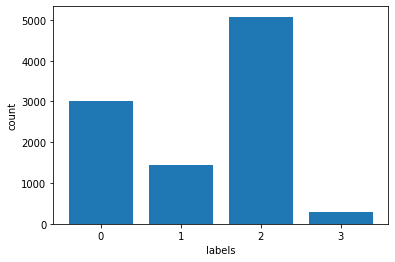

In [10]:
plt.bar(range(len(label_counts)), list(label_counts.values()), tick_label=list(label_counts.keys()))
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

To create a veracity prediction model, a transformer architecture called DistilBERT is used. Transformer model encodes the entire sequence at once, and is thus able to learn word embeddings with a deeper context compared to LSTMs. DistilBERT is a lightweight version of BERT while maintaing comparable performance. The DistilBERT model is fine-tuned on pub_health dataset to predict the veracity of claims.

The data is preprocessed to meet the input requirements of DistilBERT as shown below.

In [11]:
# loading distilbert tokenizer from hugging face to tokenize pub_health dataset
# in the same manner

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

The following sections consider various fields in the training data. Ideally, only the "claim" field should be included in training as this closely reflects the "test" scenario. For experimentation purposes, the explanation field is also included in a secondary test scenario.

In [12]:
def preprocess_function(data):
    return tokenizer(data["claim"], padding="max_length", truncation=True)

In [13]:
tokenized_pub_claims = pub_dataset.map(preprocess_function, batched=True)

Parameter 'function'=<function preprocess_function at 0x7f33e21f3680> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [14]:
def preprocess_function(data):
    return tokenizer(data["explanation"], padding="max_length", truncation=True)

In [15]:
tokenized_pub_explanation = tokenized_pub_claims.map(preprocess_function, batched=True)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [16]:
tokenized_pub_explanation['train'][0].keys()

dict_keys(['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects', 'input_ids', 'attention_mask'])

## PyTorch for flexible model building

In [17]:
def get_dataloaders(tokenized_pub):
    """
    this function takes in a dataset object and wraps PyTorch dataloader class 
    to create train, val, and test sets
    """
    tokenized_pub = tokenized_pub.rename_column("label", "labels")
    tokenized_pub.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    train = tokenized_pub['train']
    val = tokenized_pub['validation']
    test = tokenized_pub['test']

    train_dataloader = DataLoader(train, shuffle=True)
    val_dataloader = DataLoader(val, shuffle=True)
    test_dataloader = DataLoader(test)
    
    return train_dataloader, val_dataloader, test_dataloader

In [18]:
from transformers import get_scheduler
from tqdm.auto import tqdm
from datasets import load_metric

metric = load_metric("accuracy")

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print ('using {} device'.format(device))

using cuda device


In [20]:
def eval_block(model, dataloader, metric, return_predictions=False):
    """
    Returns the accuracy of prediction of a model on the data given a performace
    metric. Model is set to eval model.
    """
    model.eval()
    predictions_list = []
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        predictions_list.append(predictions)
        metric.add_batch(predictions=predictions, references=batch["labels"])

    val_accuracy = metric.compute()['accuracy']
    
    if return_predictions:
        return (val_accuracy, predictions_list)
    return val_accuracy

In [21]:
def train_loop(epochs, model, optimizer, train_dataloader, val_dataloader, lr_scheduler):
    """
    Perfoms training on the entire dataset given the optimizer and learning rate.
    Checkpoint of model is created based on the performance on the validation set 
    to avoid overfitting.
    """
    min_val_accuracy = 0
    training_steps = epochs * len(train_dataloader)
    progress_bar = tqdm(range(training_steps))
    for epoch in range(epochs): 
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
            progress_bar.update(1)

        val_accuracy = eval_block(model, val_dataloader, metric)
        if val_accuracy > min_val_accuracy:
            min_val_accuracy = val_accuracy
            print ('accuracy increased, creating checkpoint')
            torch.save(model.state_dict(), PATH)

    print('Finished Training')

In [24]:
def train_model(train_dataloader, val_dataloader, PATH, epochs):
    """
    Intializes pretrained Distilbert model and fine-tunes it on the training data
    """
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", \
                                                               num_labels=len(unique_labels))
    
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-5)

    training_steps = epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, \
                                 num_training_steps=training_steps)
    
    train_loop(epochs, model, optimizer, train_dataloader, val_dataloader, lr_scheduler)

In [45]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(tokenized_pub_claims)

In [35]:
PATH = 'veracity_prediction_final.pth'
epochs = 3
train_model(train_dataloader, val_dataloader, PATH, epochs)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

  0%|          | 0/29412 [00:00<?, ?it/s]

[1,  2000] loss: 0.922
[1,  4000] loss: 0.834
[1,  6000] loss: 0.815
[1,  8000] loss: 0.765
accuracy increased, creating checkpoint
[2,  2000] loss: 0.700
[2,  4000] loss: 0.698
[2,  6000] loss: 0.671
[2,  8000] loss: 0.661
accuracy increased, creating checkpoint
[3,  2000] loss: 0.527
[3,  4000] loss: 0.503
[3,  6000] loss: 0.500
[3,  8000] loss: 0.506
Finished Training


In [36]:
# perform evaluation on the test set and get accuracy and predictions for 
# generating confusion matrix

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", \
                                                               num_labels=len(unique_labels))
model.to(device)
model.load_state_dict(torch.load(PATH))
accuracy, predictions_list = eval_block(model, test_dataloader, metric, return_predictions=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [37]:
print ('accuracy on test set {}'.format(accuracy))

accuracy on test set 0.6601784266017843


The model achieves considerably high performance than random chance but it could be improved further. Creating a more balanced training set representing all classes might help increase the accuracy.

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [30]:
y_test = [batch["labels"].item() for batch in test_dataloader]
predictions_list = [pred.item() for pred in predictions_list]

In [33]:
print (classification_report(y_test, predictions_list))

              precision    recall  f1-score   support

           0       0.48      0.90      0.63       388
           1       0.67      0.01      0.02       201
           2       0.86      0.72      0.79       599
           3       0.00      0.00      0.00        45

    accuracy                           0.64      1233
   macro avg       0.50      0.41      0.36      1233
weighted avg       0.68      0.64      0.58      1233



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Considering the imbalance of data, the majority classes 0 and 2 are predicted well by the model. Class 3 gets zero predictions indicating that class balance should be maintained across all labels.

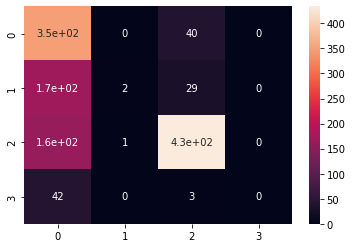

In [34]:
sns.heatmap(confusion_matrix(y_test, predictions_list), annot=True)

In the next step, the column "explanations" in the training data is also included. The column "Explanations" gives brief descriptions of the reasoning behind the label which could help the model learn more information. However, the test data cannot be expected to have this field in a real-world setting.

In [48]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(tokenized_pub_explanation)

In [39]:
PATH = 'veracity_prediction_final_explanations.pth'
epochs = 3
train_model(train_dataloader, val_dataloader, PATH, epochs)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

  0%|          | 0/29412 [00:00<?, ?it/s]

[1,  2000] loss: 0.931
[1,  4000] loss: 0.814
[1,  6000] loss: 0.741
[1,  8000] loss: 0.723
accuracy increased, creating checkpoint
[2,  2000] loss: 0.599
[2,  4000] loss: 0.563
[2,  6000] loss: 0.574
[2,  8000] loss: 0.605
accuracy increased, creating checkpoint
[3,  2000] loss: 0.446
[3,  4000] loss: 0.421
[3,  6000] loss: 0.402
[3,  8000] loss: 0.406
accuracy increased, creating checkpoint
Finished Training


In [49]:
# perform evaluation on the test set and get accuracy and predictions for 
# generating confusion matrix

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", \
                                                               num_labels=len(unique_labels))
model.to(device)
model.load_state_dict(torch.load(PATH))
accuracy, predictions_list = eval_block(model, test_dataloader, metric, return_predictions=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [52]:
print ('accuracy on test set {}'.format(accuracy))

accuracy on test set 0.7201946472019465


In [53]:
y_test = [batch["labels"].item() for batch in test_dataloader]
predictions_list = [pred.item() for pred in predictions_list]

In [54]:
print (classification_report(y_test, predictions_list))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67       388
           1       0.50      0.46      0.48       201
           2       0.84      0.86      0.85       599
           3       0.50      0.29      0.37        45

    accuracy                           0.72      1233
   macro avg       0.62      0.58      0.59      1233
weighted avg       0.71      0.72      0.72      1233



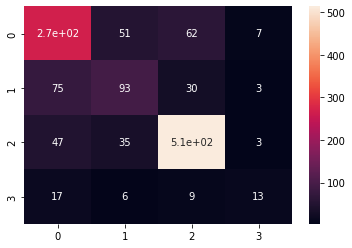

In [55]:
sns.heatmap(confusion_matrix(y_test, predictions_list), annot=True)

As expected, the model with input explanations performs slightly better than claims only model. Augmenting the dataset with new information helps the model learn better. The minority classes are also detected well compared to the claims only model where it achieved zero predictions for classes 1 and 3.

## Conclusion

The "claims" only model achieved 66% accuracy (58% weighted f-1 score) while the "claims and explanation" model achieved 72% accuracy (72% weighted f-1 score). As the classes are imbalanced, f-1 score is a better indicator of the robustness of the model, and the input data with explanations help the model predict the claims better.

Further exploration:
- Increase the size of dataset with balanced classes
- Perform experiments with different transformer architectures